In [ ]:
import pandas as pd
import glob 
import os
from tqdm import tqdm
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from itertools import cycle, islice

In [ ]:
!pip install transformers

In [ ]:
df = pd.read_csv('/content/train.tsv',sep='\t')

In [ ]:
len(df)

24988

In [ ]:
percent_10 = df.sample(n=2498)
percent_10.to_csv('train_10_10_Percent_2.tsv',sep='\t',index=False)
idxs_not_in_sample = [idx for idx in df.index if idx not in percent_10.index]
# idxs_not_in_sample

# locate the rows at the indices in the original dataframe that aren't in the sample
not_sample = df.loc[idxs_not_in_sample]
not_sample.to_csv('train_10_remaining_clean.tsv',sep='\t',index=False)

In [ ]:
os.chdir('/content/')

In [ ]:
!python label_randomizer.py

22490it [00:01, 11742.63it/s]


In [ ]:
!python findObfuscationIndex.py

22490it [00:43, 515.15it/s]
11230


In [ ]:
corrupted_indices = []
with open('/content/corrupted_indices_10_saved') as f:
  allRows = f.readlines()
  for row in allRows:
    corrupted_indices.append(int(row.strip('\n')))

In [ ]:
!python run_classifier.py --data_dir /content/  --bert_model roberta-large --task_name imdb --output_dir /content/IMDB_1 --cache_dir pytorch_cache  --do_eval --do_lower_case --do_resume --do_train 

In [ ]:
!pip install thundersvm-cuda10

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
i=9
!python /content/AFLiteImplementationCleaned_Imdb.py {i}

Streaming output truncated to the last 5000 lines.
        0.2557224 , -0.23662914], dtype=float32), array([-0.3081343 ,  0.82954836, -0.5552009 , ..., -0.0683039 ,
        0.2562955 , -0.25626603], dtype=float32), array([-0.32749894,  0.819255  , -0.5527234 , ..., -0.06363712,
        0.27371714, -0.24720636], dtype=float32), array([-0.31948417,  0.8318391 , -0.5350133 , ..., -0.08190834,
        0.24903393, -0.22433855], dtype=float32), array([-0.30866355,  0.82280016, -0.55350566, ..., -0.05990935,
        0.26384005, -0.24362212], dtype=float32), array([-0.33473206,  0.8242537 , -0.5453    , ..., -0.09145463,
        0.25480232, -0.24153718], dtype=float32), array([-0.34977582,  0.82043034, -0.54501975, ..., -0.08511829,
        0.2513925 , -0.24158204], dtype=float32), array([-0.30397436,  0.8296444 , -0.55396676, ..., -0.06647827,
        0.26255035, -0.21716529], dtype=float32), array([-0.32723838,  0.8216746 , -0.5538816 , ..., -0.08201046,
        0.27354917, -0.22584577], dty

In [ ]:
# for i in range(1,10):
#   !python /content/AFLiteImplementationCleaned_Imdb.py {i}

In [ ]:
os.chdir("/content/Predictions")
P = {}
for file_name in tqdm(sorted(glob.glob("firstIteration_50_*_clean.csv"))):
  df = pd.read_csv(file_name,header=None)
  for key,value in zip(df[0],df[1]):
    if key in P.keys():
      P[key].append(value)
    else:
      P[key]=[value]

100%|██████████| 10/10 [00:00<00:00, 50.88it/s]


In [ ]:
full_predictions = pd.DataFrame.from_dict(P,orient='index')

In [ ]:
mask = [] 
notmask = []
for index_value in tqdm(full_predictions.index):
  if index_value in corrupted_indices:
    mask.append(True)
    notmask.append(False)
  else:
    mask.append(False)
    notmask.append(True)

100%|██████████| 22490/22490 [00:02<00:00, 8467.36it/s]


In [ ]:
corrupted_predictions = full_predictions[mask]
noncorrupted_predictions = full_predictions[notmask]

In [ ]:
mean_predictions_full = []
mean_predictions_corr = []
mean_predictions_nocorr = []
for index,row in full_predictions.iterrows():
  mean_predictions_full.append(np.mean(row))
for index,row in corrupted_predictions.iterrows():
  mean_predictions_corr.append(np.mean(row))
for index,row in noncorrupted_predictions.iterrows():
  mean_predictions_nocorr.append(np.mean(row))

full_predictions['mean']=mean_predictions_full
corrupted_predictions['mean']=mean_predictions_corr
noncorrupted_predictions['mean']=mean_predictions_nocorr

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [ ]:
def unionBool(lst1,lst2):
  mask = []
  for i,j in zip(lst1,lst2):
    mask.append(i and j)
  return mask

In [ ]:
def getHeights(df):
  heights = []
  for i in range(0,10):
    lst1 = i*0.1<df['mean']
    lst2 = df['mean']<(i+1)*0.1
    mask = unionBool(lst1,lst2)
    heights.append(len(df[mask]))
  return heights

In [ ]:
heights_corrupted = getHeights(corrupted_predictions)
heights_noncorrupted = getHeights(noncorrupted_predictions)

In [ ]:
heights_corrupted

[0, 1, 30, 961, 4079, 4025, 939, 50, 0, 0]

In [ ]:
heights_noncorrupted

[0, 1, 34, 1128, 5016, 4957, 1208, 42, 0, 0]

In [ ]:
ratio = []
for i,j in zip(heights_corrupted,heights_noncorrupted):
  if j!=0:
    ratio.append(i/j)
  else:
    ratio.append(0)

In [ ]:
ratio

[0,
 1.0,
 0.8823529411764706,
 0.8519503546099291,
 0.8131977671451356,
 0.8119830542666936,
 0.777317880794702,
 1.1904761904761905,
 0,
 0]

<BarContainer object of 10 artists>

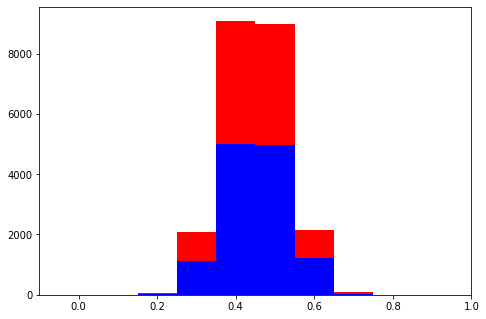

In [ ]:
fig = plt.figure()
width = 0.1
ind = np.arange(0.0, 1.0, 0.1)
ax = fig.add_axes([0,0,1,1])
ax.bar(ind, heights_noncorrupted, width, color='b')
ax.bar(ind, heights_corrupted, width,bottom=heights_noncorrupted, color='r')

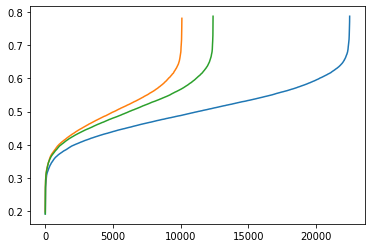

In [ ]:
plt.plot(sorted(mean_predictions_full))
plt.plot(sorted(mean_predictions_corr))
plt.plot(sorted(mean_predictions_nocorr))

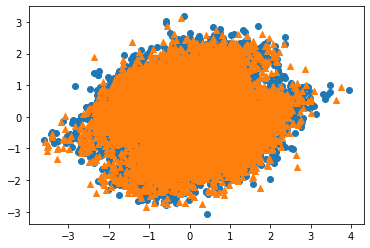

In [ ]:
pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(noncorrupted_predictions)
plt.scatter(X_pca[:,0],X_pca[:,1])
pca = PCA(n_components=2, whiten=True)
X_pca = pca.fit_transform(corrupted_predictions)
plt.scatter(X_pca[:,0],X_pca[:,1],marker="^")